/home/apra/Projects/apra-howfsc-models/apra_pop_models
6.069 mm


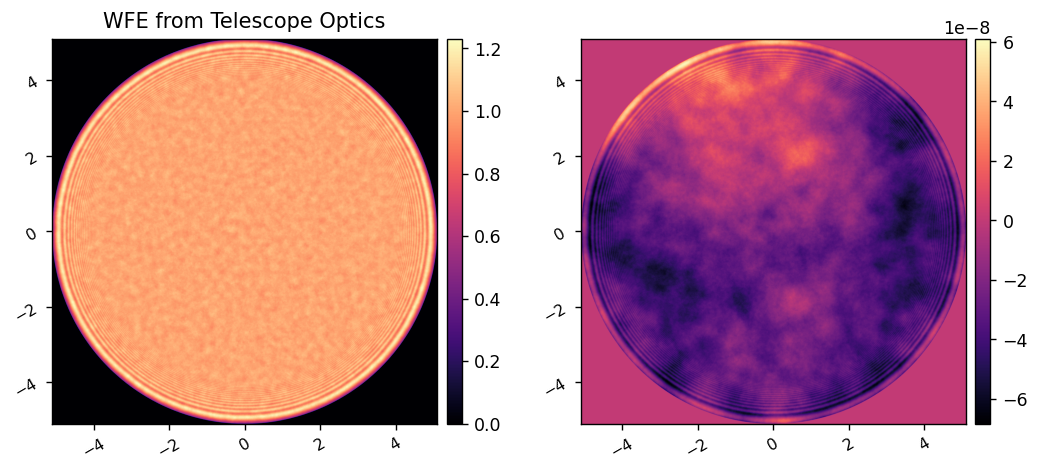

In [1]:
# import sys
# sys.path.append('..')

import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_poppy as fresnel
import apra_pop_models.fraunhofer_coro_poppy as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array

from apra_pop_models.imshows import *

pupil_diam = 10.2*u.mm
focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam * focal_ratio
print(lyot_diam)

wavelength_c = 650e-9*u.m

vortex = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2)

ote_wfe_fname = '../ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix))

In [15]:
lyot_pupil = pupil_diam * focal_ratio
display(lyot_pupil)

display(coro.psf_pixelscale_lamD)
pxscl = wavelength_c*coro.fl_oap5/(lyot_pupil)/4
display(pxscl)

<Quantity 7.14 mm>

0.25

<Quantity 4.55182073e-06 m>

/home/apra/Projects/apra-howfsc-models/apra_pop_models


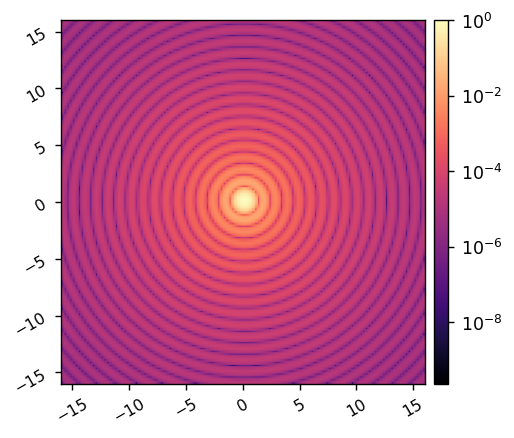

In [2]:
reload(fresnel)
poppy_log.disabled = True

coro = fresnel.CORO(psf_pixelscale_lamD=1/4)

coro.npix = 256
coro.oversample = 4
coro.npsf = 128

coro.OTEWFE = OTE_WFE

coro.use_opds = False
# coro.use_opds = True

coro.im_norm = coro.snap().max()

ref_im = coro.snap()
imshow1(ref_im, pxscl=coro.psf_pixelscale_lamD, lognorm=True)




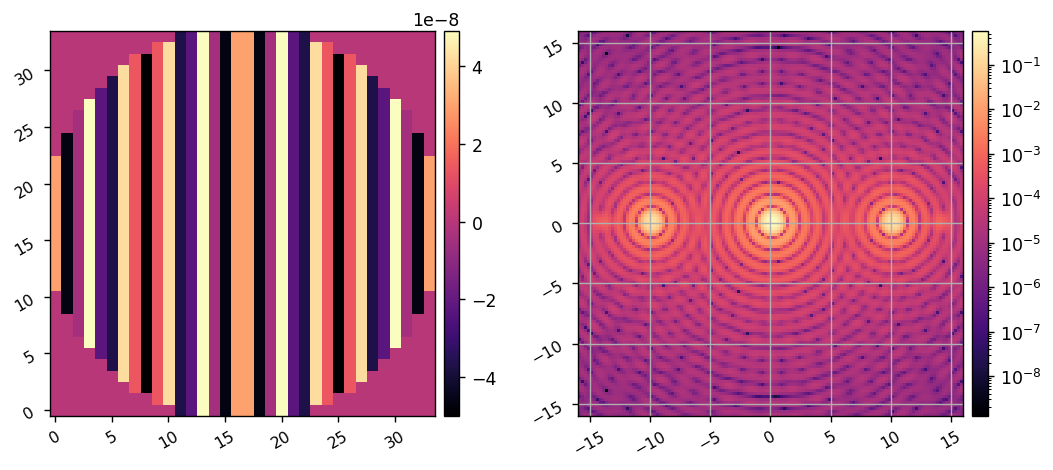

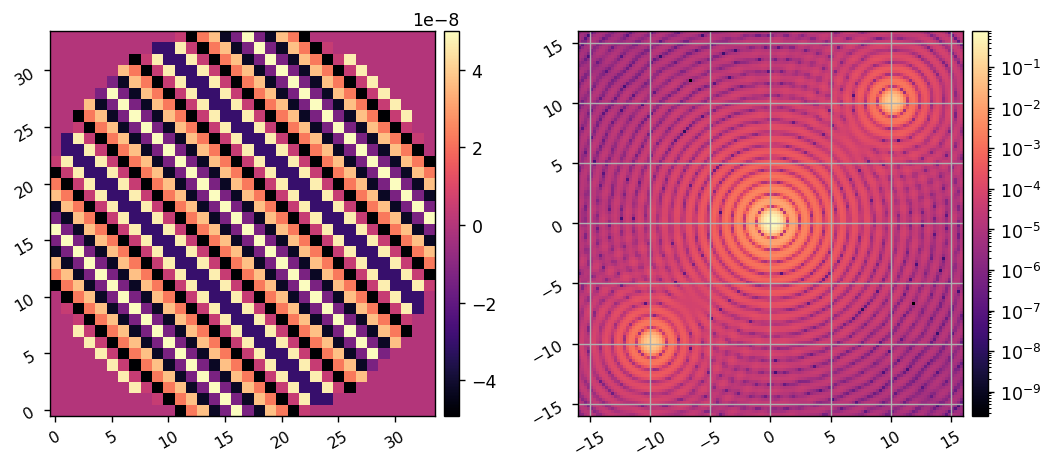

In [3]:
poppy_log.disabled = True

coro.use_opds = False
# coro.use_opds = True

Nact = coro.Nact
xpp = np.linspace(-coro.Nact/2, coro.Nact/2-1, coro.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 5e-8

separation = 10
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*coro.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*coro.dm_mask

coro.set_dm(com_1)
im1 = coro.snap()
imshow2(coro.get_dm(), im1, pxscl2=coro.psf_pixelscale_lamD, lognorm2=True, grid2=True)

coro.set_dm(com_2)
im2 = coro.snap()
imshow2(coro.get_dm(), im2, pxscl2=coro.psf_pixelscale_lamD, lognorm2=True, grid2=True)

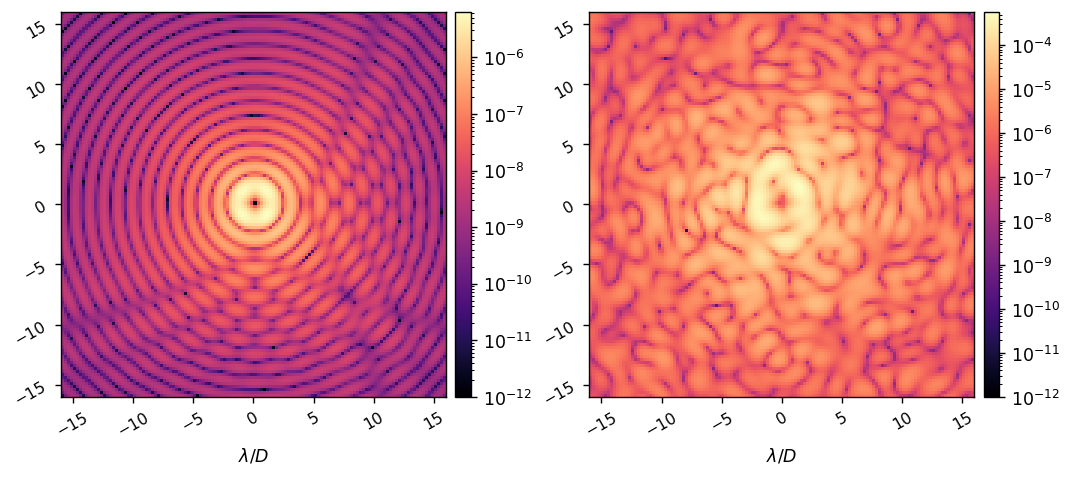

In [4]:
poppy_log.disabled = True

coro.reset_dm()

coro.FPM = vortex
coro.LYOT = lyot_stop

coro.use_opds = False
occ_im_no_opds = coro.snap()

coro.use_opds = True
occ_im_with_opds = coro.snap()

imshow2(occ_im_no_opds, occ_im_with_opds,
        pxscl=coro.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, 
        vmin1=1e-12, vmin2=1e-12)



In [5]:
coro.use_opds=False
wfs = coro.calc_wfs()

Propagating wavelength 650.000 nm.
PSF calculated in 2.166s


In [6]:
for i in range(len(wfs)):
    print(wfs[i].location)

after Circle, radius=5.0 mm
after OAP0
after Int Focal Plane
after OAP0
after DM
after OAP1
after Int Focal Plane
after OAP2
after Apodizer Place-holder
after OAP3
after VVC
after OAP4
after Lyot Stop Plane
after Lyot Stop
after OAP5
at Detector


# Check difference in speckle field with two different WFE datasets from the telescope optics

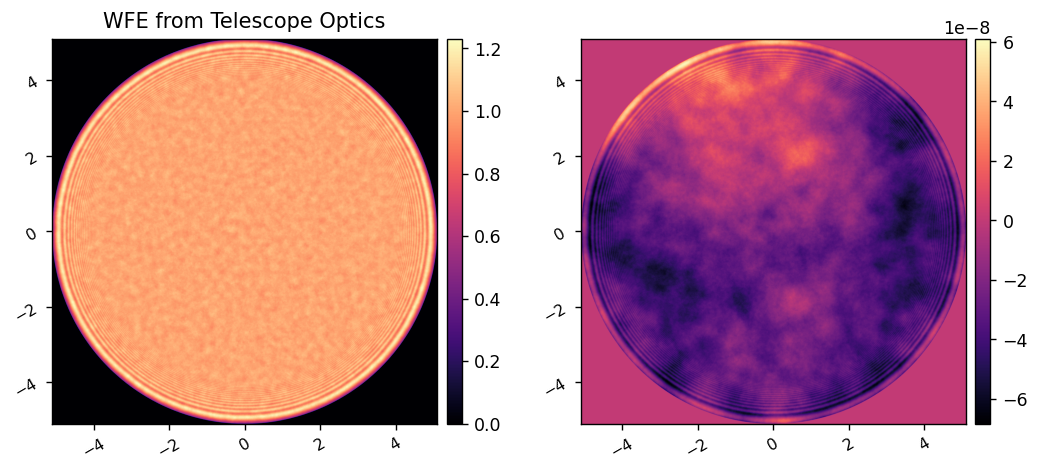

FileNotFoundError: [Errno 2] No such file or directory: 'ote-wfe-data/telescope_wfe_2.fits'

In [43]:
ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE_1 = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE_1.amplitude,OTE_WFE_1.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE_1.pixelscale.to(u.mm/u.pix))

ote_wfe_fname = 'ote-wfe-data/telescope_wfe_2.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE_2 = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE_2.amplitude, OTE_WFE_2.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE_2.pixelscale.to(u.mm/u.pix))

reload(full)
c = full.CORO()

coro.npix = 256
coro.oversample = 16
coro.use_opds = True

coro.APODIZER = None
coro.FPM = vortex
coro.LYOT = lyot_stop

coro.OTEWFE = OTE_WFE_1
im1=coro.snap()

coro.OTEWFE = OTE_WFE_2
im2=coro.snap()


imshow3(im1, im2, im1-im2, lognorm1=True, lognorm2=True)